Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]

In [ ]:
import time
import os
import sys
import shutil
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2021-09-13 11:30:21--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.168.3
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.168.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  48.5MB/s    in 6m 26s  

2021-09-13 11:36:47 (47.7 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2021-09-13 11:36:48--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.138.33
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.138.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  49.3MB/s    in 16s     

2021-09-13 11:37:04 (47.9 MB/s) - ‘val

In [ ]:
%tensorflow_version 2.x

In [ ]:
COCO_ROOT = './data/'
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

Класс для сегментационного датасета COCO  
Класс наследутся от универсльного Dataset и реализует кастомную функцию чтения данных.

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        img_cand_list = self.coco.getImgIds(catIds=self.cat_ids)
        self.img_list = []
        for im in img_cand_list:
            if len(self.img_list) < 3200:
                # img_id = int(im.numpy())
                img_data = self.coco.loadImgs(im)[0]
                img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

                if os.path.isfile(os.path.join(COCO_ROOT, img_fname)):
                    self.img_list.append(im)
            else:
                break

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=15.40s)
creating index...
index created!
loading annotations into memory...
Done (t=2.43s)
creating index...
index created!


In [ ]:
len(COCO_dataset_train.img_list), len(COCO_dataset_train.cat_ids)

(3200, 1)

In [ ]:
NUM_EPOCHS = 2
BATCH_SIZE = 16

In [ ]:
train_ds = COCO_dataset_train.train_dataset(BATCH_SIZE, NUM_EPOCHS, 256)
val_ds = COCO_dataset_val.val_dataset(BATCH_SIZE, 256)

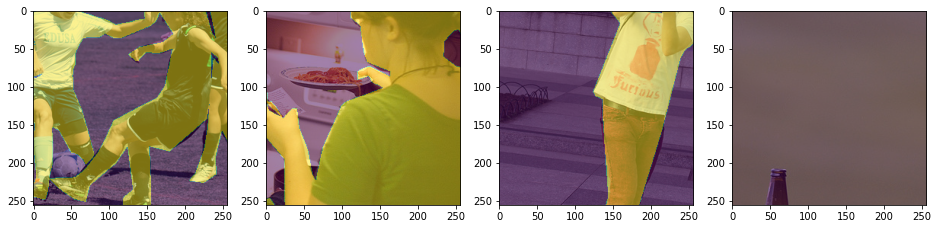

In [ ]:
img, mask = next(iter(train_ds.take(1)))

plt.figure(figsize=(16, 4))
for i in range(2):
    plt.subplot(1, 4, i+1)
    plt.imshow(img[i])
    plt.imshow(mask[i, ..., 0], alpha=0.5)

Model

In [ ]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

Обучение модели

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

EXP_NAME = 'transfer'

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

In [ ]:
hist = model.fit(train_ds, 
                 batch_size=16, 
                 validation_data=val_ds, 
                 epochs=5, 
                 callbacks=[tensorboard_callback])

Epoch 1/5
400/400 [==============================] - 458s 1s/step - loss: 0.4112 - accuracy: 0.8036 - val_loss: 0.4348 - val_accuracy: 0.7876
Epoch 2/5
400/400 [==============================] - 459s 1s/step - loss: 0.3980 - accuracy: 0.8077 - val_loss: 0.4101 - val_accuracy: 0.8012
Epoch 3/5
400/400 [==============================] - 460s 1s/step - loss: 0.3830 - accuracy: 0.8155 - val_loss: 0.4075 - val_accuracy: 0.8010
Epoch 4/5
400/400 [==============================] - 459s 1s/step - loss: 0.3766 - accuracy: 0.8193 - val_loss: 0.3873 - val_accuracy: 0.8145
Epoch 5/5
400/400 [==============================] - 460s 1s/step - loss: 0.3616 - accuracy: 0.8287 - val_loss: 0.4062 - val_accuracy: 0.8038


Оценка качества модели

In [ ]:
model.evaluate(val_ds)

168/168 [==============================] - 73s 435ms/step - loss: 0.4062 - accuracy: 0.8038


[0.4061889052391052, 0.8038443326950073]

View train pred

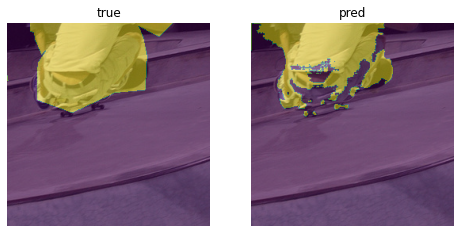

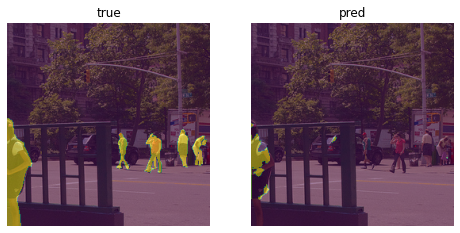

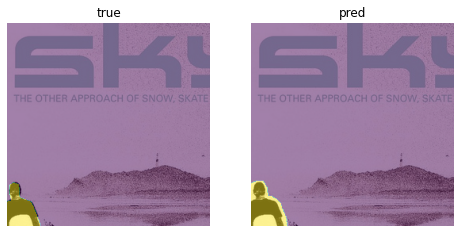

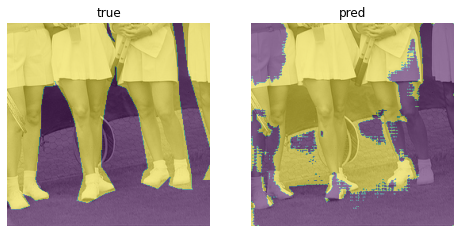

In [ ]:
PERCEPTION = 0.5

train_x, train_y = next(iter(train_ds))

pred_prob = model(train_x[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('true')
    plt.imshow(train_x[i])
    plt.imshow(train_y[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('pred')
    plt.imshow(train_x[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')

View val pred

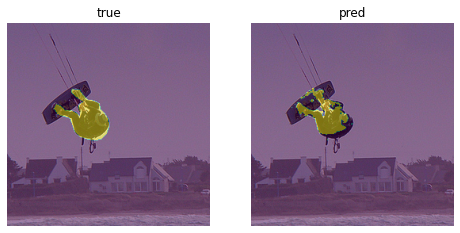

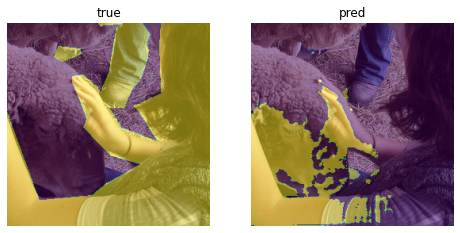

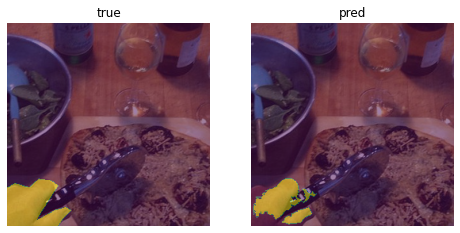

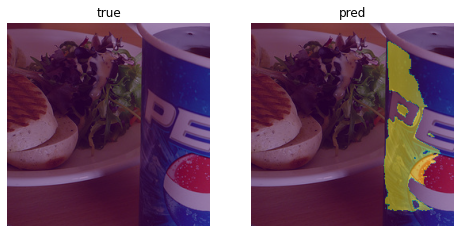

In [ ]:
val_x, val_y = next(iter(val_ds))

pred_prob = model(val_x[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('true')
    plt.imshow(val_x[i])
    plt.imshow(val_y[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('pred')
    plt.imshow(val_x[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')

Как- то так. Можно доучить. На 20 эпохах думаю пробьет 0,90